# Training Logistic Regression via Stochastic Gradient Ascent

The goal of this notebook is to implement a logistic regression classifier using stochastic gradient ascent. I will:
* Write a function to compute the derivative of log likelihood function with respect to a single coefficient.
* Implement stochastic gradient ascent.
* Compare convergence of stochastic gradient ascent with that of batch gradient ascent.


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import scipy.io
from PIL import Image
from scipy import ndimage
import csv
import math
import os
import sys
import sklearn
import sklearn.datasets
from sklearn.preprocessing import scale

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

from __future__ import division

# GD vs. SGD vs. Mini-batch GD:

In Stochastic Gradient Descent, you use only 1 training example before updating the gradients. When the training set is large, SGD can be faster. But the parameters will "oscillate" toward the minimum rather than converge smoothly. Here is an illustration of this: 

<img src="images/kiank_sgd.png" style="width:750px;height:250px;">
<caption><center> <u> <font color='purple'> **Figure 1** </u><font color='purple'>  : **SGD vs GD**<br> "+" denotes a minimum of the cost. SGD leads to many oscillations to reach convergence. But each step is a lot faster to compute for SGD than for GD, as it uses only one training example (vs. the whole batch for GD). </center></caption>


In practice, you'll often get faster results if you do not use neither the whole training set, nor only one training example, to perform each update. Mini-batch gradient descent uses an intermediate number of examples for each step. With mini-batch gradient descent, you loop over the mini-batches instead of looping over individual training examples.

<img src="images/kiank_minibatch.png" style="width:750px;height:250px;">
<caption><center> <u> <font color='purple'> **Figure 2** </u>: <font color='purple'>  **SGD vs Mini-Batch GD**<br> "+" denotes a minimum of the cost. Using mini-batches in your optimization algorithm often leads to faster optimization. </center></caption>

# Function for loading data:

In [6]:
def load_data(file_name):
    """
    This function load the data into the data structures that we need.
    """
    X = np.loadtxt(file_name, dtype='float', delimiter=',', usecols=np.arange(3,13))
    X1 = scale(X, axis=1)
    X = np.hstack((np.ones((X.shape[0],1)), X1))

    cl = np.loadtxt(file_name, dtype='str', delimiter=',', usecols=[1])
    # Set Malignant to be 1 and Benign to be 0
    y = (cl == 'M').astype(float)

    train_set_x = X
    train_set_y = y

    test_set_x = train_set_x
    test_set_y = train_set_y
    
    return (train_set_x, train_set_y, test_set_x, test_set_y)

## Function to load a dataset from sklearn datasets

In [45]:
def load_dataset():
    np.random.seed(3)
    train_X, train_Y = sklearn.datasets.make_moons(n_samples=300, noise=.2) #300 #0.2 
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    
    return train_X, train_Y

# train_X, train_Y = load_dataset()

## Shuffle and Partitioning of the data

In [29]:
# GRADED FUNCTION: random_mini_batches

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            
    m = X.shape[0]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :].reshape((m, 1))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : (k+1) * mini_batch_size, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : (k+1)* mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[(k+1) * mini_batch_size : m, :]
        mini_batch_Y = shuffled_Y[(k+1) * mini_batch_size : m, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [30]:
# Unit testing function

file_name = '../../../data/wdbc.csv'
train_set_x, train_set_y, _, _ = load_data(file_name)
train_set_y = train_set_y.reshape(train_set_y.shape[0],1)
mini_batch_size = 64

print(train_set_y.shape)

mini_batches = random_mini_batches(train_set_x, train_set_y, mini_batch_size=mini_batch_size)

print ("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print ("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print ("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print ("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print ("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape)) 
print ("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))

print("number of mini_batches", len(mini_batches))

(569, 1)
shape of the 1st mini_batch_X: (64, 11)
shape of the 2nd mini_batch_X: (64, 11)
shape of the 3rd mini_batch_X: (64, 11)
shape of the 1st mini_batch_Y: (64, 1)
shape of the 2nd mini_batch_Y: (64, 1)
shape of the 3rd mini_batch_Y: (64, 1)
number of mini_batches 9


In [16]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    score = np.dot(feature_matrix, coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    predictions = 1. / (1.+np.exp(-score))    
    return predictions

## Derivative of log likelihood with respect to a single coefficient

Let us now work on making minor changes to how the derivative computation is performed for logistic regression.

Recall from the lectures and Module 3 notebook that for logistic regression, **the derivative of log likelihood with respect to a single coefficient** is as follows:

$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

In Module 3 notebook, we wrote a function to compute the derivative of log likelihood with respect to a single coefficient $w_j$. The function accepts the following two parameters:
 * `errors` vector containing $(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w}))$ for all $i$
 * `feature` vector containing $h_j(\mathbf{x}_i)$  for all $i$
 

In [17]:
def feature_derivative(errors, feature): 
    
    # Compute the dot product of errors and feature
    derivative = np.dot(errors, feature)

    return derivative

To track the performance of stochastic gradient ascent, I implement a function for computing **average log likelihood**. 

$$\ell\ell_A(\mathbf{w}) = \color{red}{\frac{1}{N}} \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) $$

In [18]:
def compute_avg_log_likelihood(feature_matrix, sentiment, coefficients):
    
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]
    
    lp = np.sum((indicator-1)*scores - logexp)/len(feature_matrix)
    
    return lp

## Implementing stochastic gradient ascent

Now we are ready to implement our own logistic regression with stochastic gradient ascent. Here is the function to fit a logistic regression model using gradient ascent:

In [91]:
from math import sqrt
def logistic_regression_SG(feature_matrix, sentiment, initial_coefficients, step_size, batch_size, max_iter):
    log_likelihood_all = []
    
    # make sure it's a numpy array
    coefficients = np.array(initial_coefficients)
    # set seed=1 to produce consistent results
    np.random.seed(seed=1)
    # Shuffle the data before starting
    permutation = np.random.permutation(len(feature_matrix))
    feature_matrix = feature_matrix[permutation,:]
    sentiment = sentiment[permutation]
    
    i = 0 # index of current batch
    # Do a linear scan over data
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,:]
        predictions = predict_probability(feature_matrix[i:i+batch_size,:], coefficients)
        
        # Compute indicator value for (y_i = +1)
        # Make sure to slice the i-th entry with [i:i+batch_size]
        indicator = (sentiment[i:i+batch_size]==+1)

        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions

        for j in range(len(coefficients)): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # Compute the derivative for coefficients[j] and save it to derivative.
            # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,j]
            derivative = feature_derivative(errors, feature_matrix[i:i+batch_size,j])
            
            # compute the product of the step size, the derivative, and the **normalization constant** (1./batch_size)
            coefficients[j] += (1./batch_size) * step_size* derivative
        
        # Checking whether log likelihood is increasing
        # Print the log likelihood over the *current batch*
        lp = compute_avg_log_likelihood(feature_matrix[i:i+batch_size,:], sentiment[i:i+batch_size],
                                        coefficients)
        log_likelihood_all.append(lp)
        if itr <= 15 or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) \
         or itr % 10000 == 0 or itr == max_iter-1:
            data_size = len(feature_matrix)
            print ('Iteration %*d: Average log likelihood (of data points in batch [%0*d:%0*d]) = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, \
                 int(np.ceil(np.log10(data_size))), i, \
                 int(np.ceil(np.log10(data_size))), i+batch_size, lp))
        
        # if we made a complete pass over data, shuffle and restart
        i += batch_size
        if i+batch_size > len(feature_matrix):
            permutation = np.random.permutation(len(feature_matrix))
            feature_matrix = feature_matrix[permutation,:]
            sentiment = sentiment[permutation]
            i = 0
                
    # We return the list of log likelihoods for plotting purposes.
    return coefficients, log_likelihood_all

In [92]:
sample_feature_matrix = np.array([[1.,2.,-1.], [1.,0.,1.]])
sample_sentiment = np.array([+1, -1])

coefficients, log_likelihood = logistic_regression_SG(sample_feature_matrix, sample_sentiment, np.zeros(3),
                                                  step_size=1., batch_size=2, max_iter=2)
print ('-------------------------------------------------------------------------------------')
print ('Coefficients learned                 :', coefficients)
print ('Average log likelihood per-iteration :', log_likelihood)
if np.allclose(coefficients, np.array([-0.09755757,  0.68242552, -0.7799831]), atol=1e-3)\
  and np.allclose(log_likelihood, np.array([-0.33774513108142956, -0.2345530939410341])):
    # pass if elements match within 1e-3
    print ('-------------------------------------------------------------------------------------')
    print ('Test passed!')
else:
    print ('-------------------------------------------------------------------------------------')
    print ('Test failed')

Iteration 0: Average log likelihood (of data points in batch [0:2]) = -0.33774513
Iteration 1: Average log likelihood (of data points in batch [0:2]) = -0.23455309
-------------------------------------------------------------------------------------
Coefficients learned                 : [-0.09755757  0.68242552 -0.7799831 ]
Average log likelihood per-iteration : [-0.33774513108142956, -0.2345530939410341]
-------------------------------------------------------------------------------------
Test passed!


## Compare convergence behavior of stochastic gradient ascent


We now **run stochastic gradient ascent** over the **feature_matrix_train** for 10 iterations using:
* `initial_coefficients = np.zeros(194)`
* `step_size = 5e-1`
* `batch_size = 1`
* `max_iter = 10`

In [105]:
file_name = '../../../data/wdbc.csv'
train_set_x, train_set_y, test_set_x, test_set_y = load_data(file_name)


coefficients, log_likelihood = logistic_regression_SG(train_set_x, train_set_y,
                                        initial_coefficients=np.zeros(11),
                                        step_size=5e-1, batch_size=1, max_iter=10)

Iteration 0: Average log likelihood (of data points in batch [000:001]) = -0.06196759
Iteration 1: Average log likelihood (of data points in batch [001:002]) = -0.04492407
Iteration 2: Average log likelihood (of data points in batch [002:003]) = -0.03544839
Iteration 3: Average log likelihood (of data points in batch [003:004]) = -0.02940398
Iteration 4: Average log likelihood (of data points in batch [004:005]) = -0.02510501
Iteration 5: Average log likelihood (of data points in batch [005:006]) = -0.02193201
Iteration 6: Average log likelihood (of data points in batch [006:007]) = -0.01952625
Iteration 7: Average log likelihood (of data points in batch [007:008]) = -0.01756173
Iteration 8: Average log likelihood (of data points in batch [008:009]) = -0.01603728
Iteration 9: Average log likelihood (of data points in batch [009:010]) = -0.01461988


Now run **batch gradient ascent** over the **feature_matrix_train** for 200 iterations using:
* `initial_coefficients = np.zeros(194)`
* `step_size = 5e-1`
* `batch_size = len(feature_matrix_train)`
* `max_iter = 200`

In [102]:
file_name = '../../../data/wdbc.csv'
train_set_x, train_set_y, test_set_x, test_set_y = load_data(file_name)

coefficients_batch, log_likelihood_batch = logistic_regression_SG(train_set_x, train_set_y,
                                        initial_coefficients=np.zeros(11),
                                        step_size=5e-1, batch_size=len(train_set_x), max_iter=200)

Iteration   0: Average log likelihood (of data points in batch [000:569]) = -0.06219655
Iteration   1: Average log likelihood (of data points in batch [000:569]) = -0.04504899
Iteration   2: Average log likelihood (of data points in batch [000:569]) = -0.03553803
Iteration   3: Average log likelihood (of data points in batch [000:569]) = -0.02942709
Iteration   4: Average log likelihood (of data points in batch [000:569]) = -0.02514844
Iteration   5: Average log likelihood (of data points in batch [000:569]) = -0.02197677
Iteration   6: Average log likelihood (of data points in batch [000:569]) = -0.01952758
Iteration   7: Average log likelihood (of data points in batch [000:569]) = -0.01757705
Iteration   8: Average log likelihood (of data points in batch [000:569]) = -0.01598573
Iteration   9: Average log likelihood (of data points in batch [000:569]) = -0.01466200
Iteration  10: Average log likelihood (of data points in batch [000:569]) = -0.01354312
Iteration  11: Average log likel

## Make "passes" over the dataset


To make a fair comparison betweeen stochastic gradient ascent and batch gradient ascent, we measure the average log likelihood as a function of the number of passes (defined as follows):
$$
[\text{# of passes}] = \frac{[\text{# of data points touched so far}]}{[\text{size of dataset}]}
$$

## Log likelihood plots for stochastic gradient ascent


With the terminology in mind, let us run stochastic gradient ascent for 10 passes. We will use
* `step_size=1e-1`
* `batch_size=100`
* `initial_coefficients` to all zeros.

In [111]:
file_name = '../../../data/wdbc.csv'
train_set_x, train_set_y, test_set_x, test_set_y = load_data(file_name)
print(len(train_set_x))

step_size = 1e-1
batch_size = 10
num_passes = 10
num_iterations = num_passes * int(len(train_set_x)/batch_size)

coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(train_set_x, train_set_y,
                                       initial_coefficients=np.zeros(11),
                                       step_size=1e-1, batch_size=10, max_iter=num_iterations)

569
Iteration   0: Average log likelihood (of data points in batch [000:010]) = -0.45563558
Iteration   1: Average log likelihood (of data points in batch [010:020]) = -0.32647434
Iteration   2: Average log likelihood (of data points in batch [020:030]) = -0.25021683
Iteration   3: Average log likelihood (of data points in batch [030:040]) = -0.20129109
Iteration   4: Average log likelihood (of data points in batch [040:050]) = -0.16791553
Iteration   5: Average log likelihood (of data points in batch [050:060]) = -0.14323171
Iteration   6: Average log likelihood (of data points in batch [060:070]) = -0.12480200
Iteration   7: Average log likelihood (of data points in batch [070:080]) = -0.11055256
Iteration   8: Average log likelihood (of data points in batch [080:090]) = -0.09905083
Iteration   9: Average log likelihood (of data points in batch [090:100]) = -0.08983130
Iteration  10: Average log likelihood (of data points in batch [100:110]) = -0.08200338
Iteration  11: Average log l

### A utility function to plot the average log likelihood as a function of the number of passes.

In [113]:
import matplotlib.pyplot as plt
%matplotlib inline

def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')
    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})

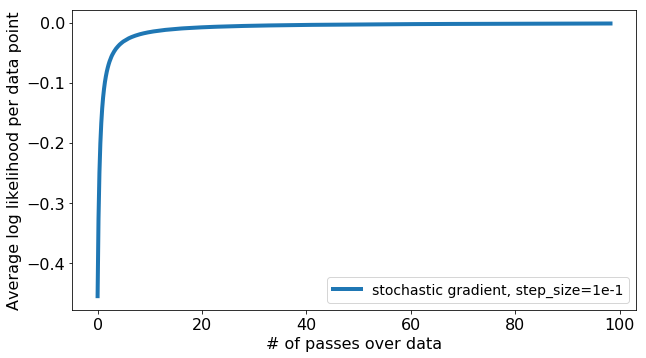

In [117]:
make_plot(log_likelihood_sgd, len_data=len(train_set_x), batch_size=100,
          label='stochastic gradient, step_size=1e-1')

## Smoothing the stochastic gradient ascent curve

The plotted line oscillates so much that it is hard to see whether the log likelihood is improving. In our plot, we apply a simple smoothing operation using the parameter `smoothing_window`. The smoothing is simply a [moving average](https://en.wikipedia.org/wiki/Moving_average) of log likelihood over the last `smoothing_window` "iterations" of  stochastic gradient ascent.

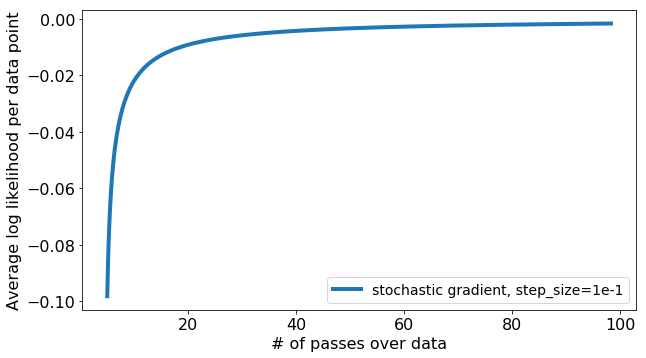

In [119]:
make_plot(log_likelihood_sgd, len_data=len(train_set_x), batch_size=100,
          smoothing_window=30, label='stochastic gradient, step_size=1e-1')

## Stochastic gradient ascent vs batch gradient ascent

To compare convergence rates for stochastic gradient ascent with batch gradient ascent, we call `make_plot()` multiple times in the same cell.

We are comparing:
* **stochastic gradient ascent**: `step_size = 0.1`, `batch_size=100`
* **batch gradient ascent**: `step_size = 0.5`, `batch_size=len(feature_matrix_train)`

Write code to run stochastic gradient ascent for 200 passes using:
* `step_size=1e-1`
* `batch_size=100`
* `initial_coefficients` to all zeros.

In [122]:
step_size = 1e-1
batch_size = 100
num_passes = 200
num_iterations = num_passes * int(len(train_set_x)/batch_size)

coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(train_set_x, train_set_y,
                                       initial_coefficients=np.zeros(11),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

Iteration   0: Average log likelihood (of data points in batch [000:100]) = -0.45574493
Iteration   1: Average log likelihood (of data points in batch [100:200]) = -0.32656818
Iteration   2: Average log likelihood (of data points in batch [200:300]) = -0.25032358
Iteration   3: Average log likelihood (of data points in batch [300:400]) = -0.20128658
Iteration   4: Average log likelihood (of data points in batch [400:500]) = -0.16769027
Iteration   5: Average log likelihood (of data points in batch [000:100]) = -0.14326103
Iteration   6: Average log likelihood (of data points in batch [100:200]) = -0.12490964
Iteration   7: Average log likelihood (of data points in batch [200:300]) = -0.11058080
Iteration   8: Average log likelihood (of data points in batch [300:400]) = -0.09914701
Iteration   9: Average log likelihood (of data points in batch [400:500]) = -0.08985282
Iteration  10: Average log likelihood (of data points in batch [000:100]) = -0.08204701
Iteration  11: Average log likel

We compare the convergence of stochastic gradient ascent and batch gradient ascent in the following cell. Note that we apply smoothing with `smoothing_window=30`.

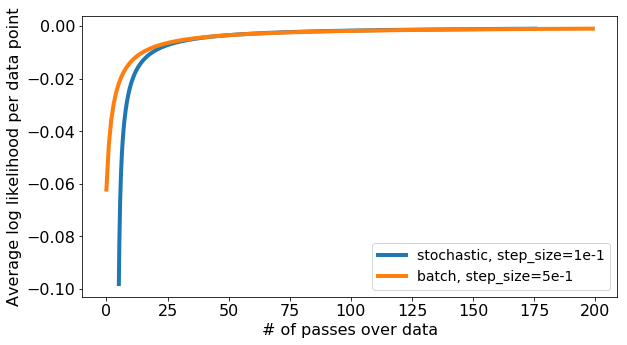

In [126]:
make_plot(log_likelihood_sgd, len_data=len(train_set_x), batch_size=100,
          smoothing_window=30, label='stochastic, step_size=1e-1')
make_plot(log_likelihood_batch, len_data=len(train_set_x), batch_size=len(train_set_x),
          smoothing_window=1, label='batch, step_size=5e-1')

## Explore the effects of step sizes on stochastic gradient ascent


In previous sections, we chose step sizes for you. In practice, it helps to know how to choose good step sizes yourself.

To start, we explore a wide range of step sizes that are equally spaced in the log space. Run stochastic gradient ascent with `step_size` set to 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, and 1e2. Use the following set of parameters:
* `initial_coefficients=np.zeros(194)`
* `batch_size=100`
* `max_iter` initialized so as to run 10 passes over the data.

In [128]:
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(train_set_x)/batch_size)

coefficients_sgd = {}
log_likelihood_sgd = {}
for step_size in np.logspace(-4, 2, num=7):
    coefficients_sgd[step_size], log_likelihood_sgd[step_size] = logistic_regression_SG(train_set_x, train_set_y,
                                       initial_coefficients=np.zeros(11),
                                       step_size=step_size, batch_size=100, max_iter=num_iterations)

Iteration  0: Average log likelihood (of data points in batch [000:100]) = -0.69287256
Iteration  1: Average log likelihood (of data points in batch [100:200]) = -0.69259812
Iteration  2: Average log likelihood (of data points in batch [200:300]) = -0.69232400
Iteration  3: Average log likelihood (of data points in batch [300:400]) = -0.69204970
Iteration  4: Average log likelihood (of data points in batch [400:500]) = -0.69177607
Iteration  5: Average log likelihood (of data points in batch [000:100]) = -0.69150185
Iteration  6: Average log likelihood (of data points in batch [100:200]) = -0.69122833
Iteration  7: Average log likelihood (of data points in batch [200:300]) = -0.69095461
Iteration  8: Average log likelihood (of data points in batch [300:400]) = -0.69068126
Iteration  9: Average log likelihood (of data points in batch [400:500]) = -0.69040873
Iteration 10: Average log likelihood (of data points in batch [000:100]) = -0.69013509
Iteration 11: Average log likelihood (of da

### Plotting the log likelihood as a function of passes for each step size

Now, we will plot the change in log likelihood using the `make_plot` for each of the following values of `step_size`:

* `step_size = 1e-4`
* `step_size = 1e-3`
* `step_size = 1e-2`
* `step_size = 1e-1`
* `step_size = 1e0`
* `step_size = 1e1`
* `step_size = 1e2`

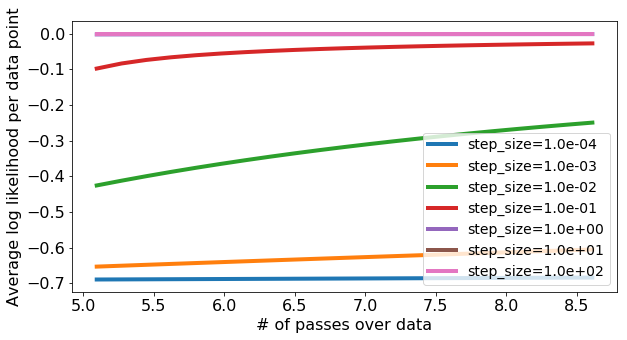

In [130]:
for step_size in np.logspace(-4, 2, num=7):
    make_plot(log_likelihood_sgd[step_size], len_data=len(train_set_x), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)

Now, let us remove the step size `step_size = 1e2` and plot the rest of the curves.

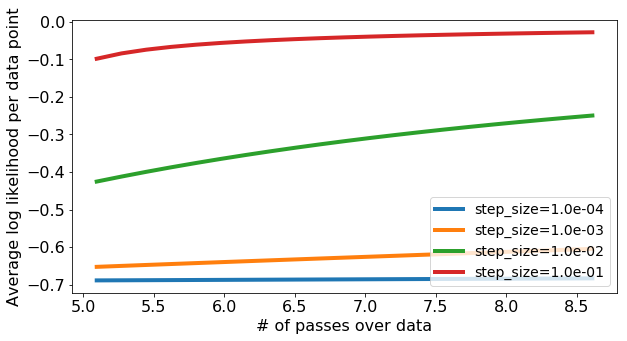

In [137]:
for step_size in np.logspace(-4, 2, num=7)[0:4]:
    make_plot(log_likelihood_sgd[step_size], len_data=len(test_set_x), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)

In [32]:
num_epochs = 10
seed = 0

for i in range(num_epochs):
    
    # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
    seed = seed + 1
    minibatches = random_mini_batches(X, Y, mini_batch_size, seed)

    for minibatch in minibatches:
        
        # Select a minibatch
        (minibatch_X, minibatch_Y) = minibatch
        
    # Print the cost every 1000 epoch
    if print_cost and i % 1000 == 0:
        print ("Cost after epoch %i: %f" %(i, cost))
    if print_cost and i % 100 == 0:
        costs.append(cost)
    

NameError: name 'X' is not defined

In [34]:
def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

In [35]:
def compute_cost(a3, Y):
    
    """
    Implement the cost function
    
    Arguments:
    a3 -- post-activation, output of forward propagation
    Y -- "true" labels vector, same shape as a3
    
    Returns:
    cost - value of the cost function
    """
    m = Y.shape[1]
    
    logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    cost = 1./m * np.sum(logprobs)
    
    return cost

In [41]:
def load_2D_dataset():
    data = scipy.io.loadmat('datasets/data.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T

    plt.scatter(train_X[0, :], train_X[1, :], c=train_Y, s=40, cmap=plt.cm.Spectral);
    
    return train_X, train_Y, test_X, test_Y

# train_X, train_Y, test_X, test_Y = load_2D_dataset()

In [42]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()